## Laboratorio di Simulazione Numerica 

# ESERCITAZIONE 4 #

### esercizio 4.1

Nel primo esercizio sono stati apportati miglioramenti al codice fornito, codice per simulazioni di Dinamica Molecolare mediante l'algoritmo di Verlet.


Scopo di questo primo esercizio era includere un modo per poter calcolare la pressione $P$, più precisamente riuscire a calcolare: 
* Le medie a blocchi
* Le medie progressive
* Le incertezze progressive

Per far ciò è stato utilizzato il teorema del Viriale, che per un potenziale di Lennard-Jones, permette di calcolare la pressione nel seguente modo:$$P = \rho k_B T + \frac{1}{3V} \left\langle \sum_{i=1}^{N-1} \sum_{j\,(>i)}^N 48\epsilon \left[ \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^{12} - 
\frac{1}{2} \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^6 \right] \right\rangle$$

### esercizio 4.2

Con il codice modificato nel precedente esercizio sono state eseguite delle simulazioni di Dinamica Molecolare secondo modello di Lennard-Jones di Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) nelle seguenti condizioni:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

Fine ultimo dell'esercizio era poi riportare dei grafici delle medie e incertezze progressive ottenute in funzione del numero di blocchi per ogni grandezza misurata, ovvero:
* energia totale interna per particella $E/N$
* energia potenziale per particella $U/N$
* energia cinetica per particella $K/N$ 
* la tempertatura $T$
* la pressione $P$

Prima di poter fare le simulazioni sono state effettuate diverse procedure che sono servite a rendere le simulazioni consistenti.

Per prima cosa la configurazione iniziale della simulazione non può essere una configurazione casuale, altrimenti si possono generare situazioni di particelle sovrapposte, e se non del tutto sovrapposte generare configurazioni che seppur aventi una certa energia interna e temperatura prima di inizare la simulazione, appena questa viene avviata a causa della forte repulsione a brevi distanze tra le particelle queste acquistano molta energia cinetica che risulta in un aumento della temperatura.

Metodo molto più adeguato è partire da una configurazione di cristallo perfetto e aspettare che il sistema evolva verso lo stato desiderato. Questo è stato il metodo utilizzato, ma vi sono due problematiche da affrontare prima della simulazione finale.

Prima di tutto si può notare che nel metodo utilizzato bisogna aspettare che il sistema evolva e si stabilizzi nella configurazione da studiare, quindi è necessario un tempo di $equilibrazione$.

In secondo luogo poiché si parte da una configurazione con temperatura uguale a quella finale desiderata (senza essere però in una configurazione compatibile con la configurazione finale alla data temperatura) e poiché ci si trova nel sistema $microcanonico$, e quindi vengono conservate l'energia totale, numero di particelle e il volume ma non la temperatura, ci si aspetta che parte dell'energia potenziale inizale venga convertita in energia cinetica o viceversa, con un conseguente aumento o diminuzione della temperatura

Pertanto si procede in primo luogo a trovare una temperatura di partenza tale che per tutte le tre fasi si abbia il sistema nelle configurazioni finali alla temperatura voluta $T^\star$

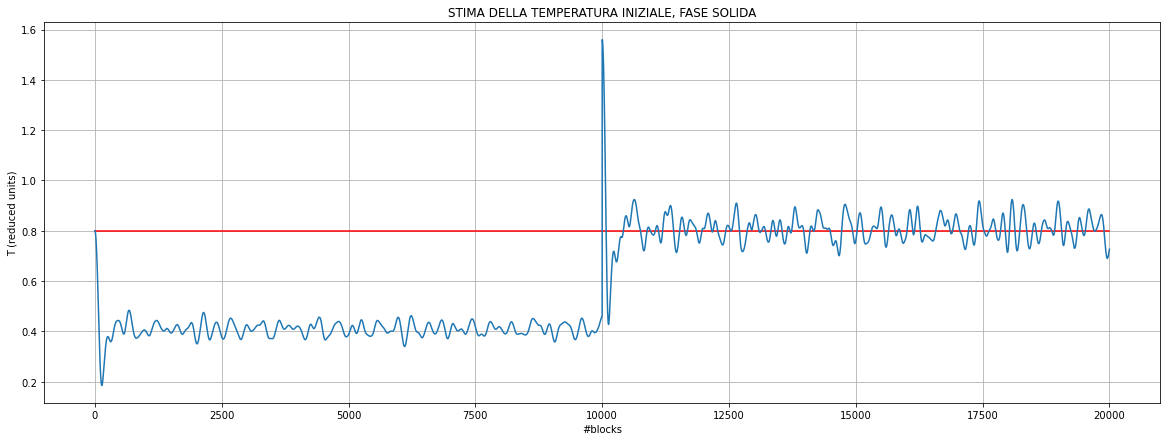

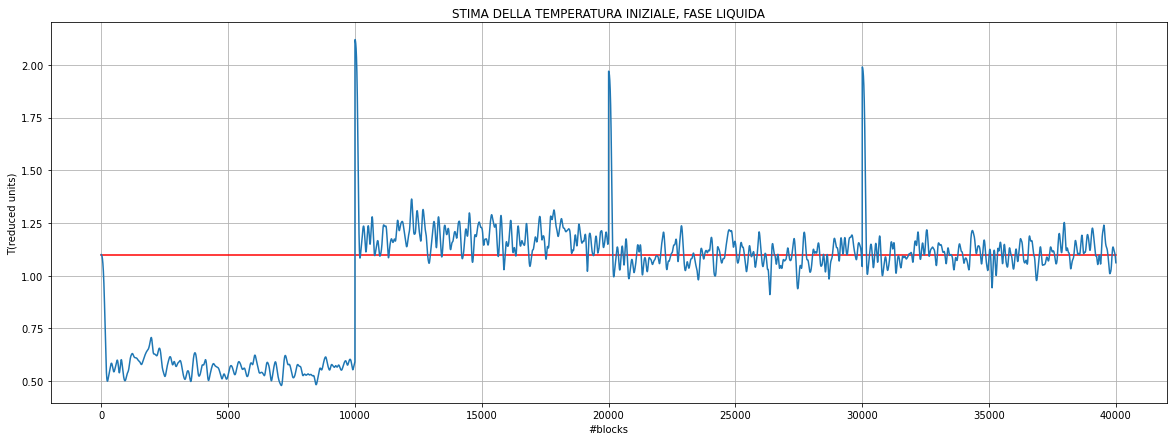

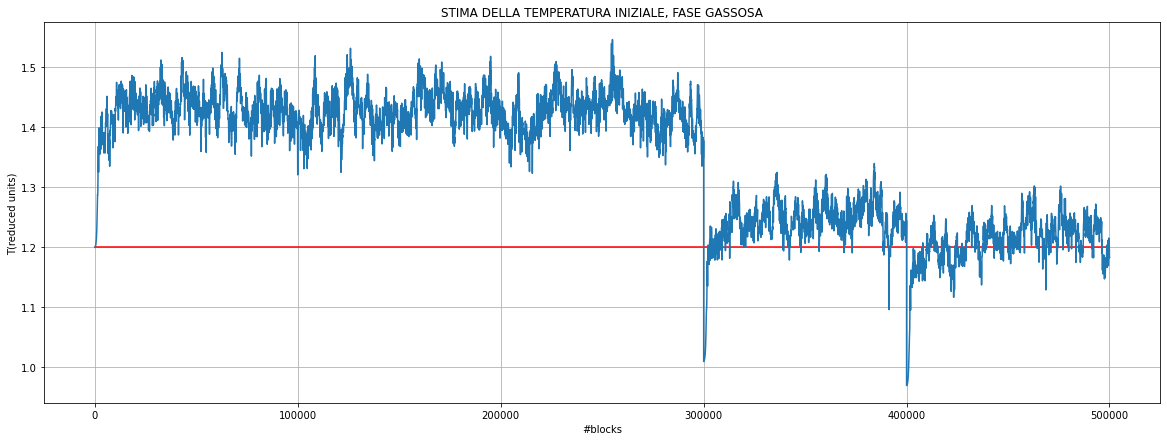

In [10]:
import matplotlib.pyplot as plt
import numpy as np

f = np.loadtxt("output_temp_sol_equilibration", usecols=(1), unpack='true')
x = np.arange(f.size)
plt.figure(figsize=(20,7))
plt.errorbar(x,f)
plt.title('STIMA DELLA TEMPERATURA INIZIALE, FASE SOLIDA')
plt.xlabel('#blocks')
plt.ylabel('T (reduced units)')
plt.plot([0,20000],[0.8,0.8], color="red")
plt.grid(True)
plt.show()


f = np.loadtxt("output_temp_liq_equilibration", usecols=(1), unpack='true')
x = np.arange(f.size)
plt.figure(figsize=(20,7))
plt.errorbar(x,f)
plt.title('STIMA DELLA TEMPERATURA INIZIALE, FASE LIQUIDA')
plt.xlabel('#blocks')
plt.ylabel('T(reduced units)')
plt.plot([0,40000],[1.1,1.1], color="red")
plt.grid(True)
plt.show()


f = np.loadtxt("output_temp_gas_equilibration", usecols=(1), unpack='true')
x = np.arange(f.size)
plt.figure(figsize=(20,7))
plt.errorbar(x,f)
plt.title('STIMA DELLA TEMPERATURA INIZIALE, FASE GASSOSA')
plt.xlabel('#blocks')
plt.ylabel('T(reduced units)')
plt.plot([0,500000],[1.2,1.2], color="red")
plt.grid(True)
plt.show()

Nei graici precedenti viene riportate le simulazioni per riuscire a stimare una temperatura di partenza adeguata, in rosso sono riportati i valori di $T^\star$.
Si può notare anche che mentre sia per la fase liquida che la fase solida vi è una diminuzione dell'energia cinetica a favore di quella potenziale che sfocia in una diminuzione della temperatura, per quanto riguarda la fase gassosa si ha un aumento di questa. Questo perché la configurazione iniziale risulta "espansa" rispetto alla configurazione del gas, e quindi questo si traduce nella diminuzione di energia potenziale che tende ad assumere il suo minimo appena parte la simulazione, con conseguente aumento della temperatura, legata all'energia cinetica. Nel gas poi la variazione iniziale risulta molto lenta, circa 2000 passi, mentre per il solido e il liquido solo circa 150.

La questione riguardante l'equilibrazione verrà invece trattata separatamente all'inizio della trattazione di ogni fase.

#### FASE SOLIDA

Nel grafico che segue è riportato l'andamento della temperatura durante la simulazione per stimare un tempo adeguato di equilibrazione.

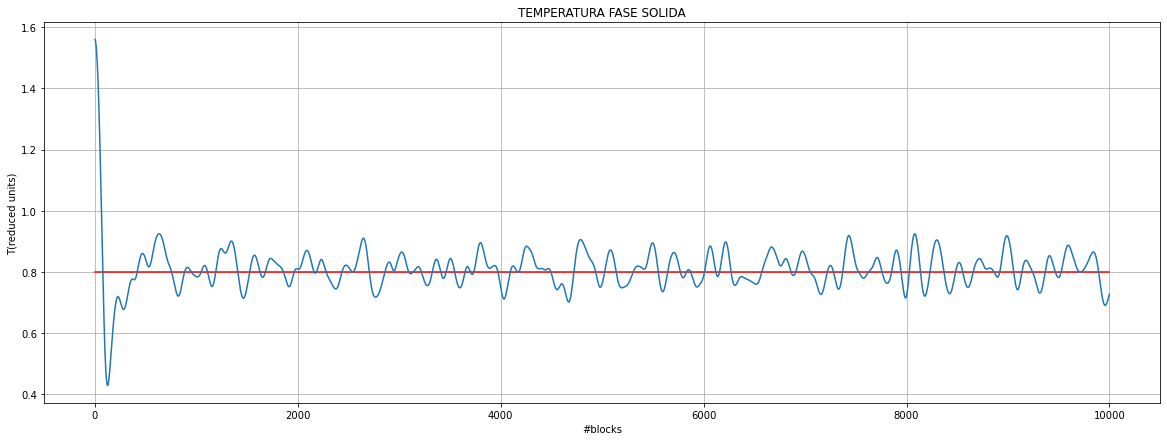

In [2]:
import matplotlib.pyplot as plt
import numpy as np

f = np.loadtxt("output_temp_sol1", usecols=(1), unpack='true')
x = np.arange(f.size)
plt.figure(figsize=(20,7))
plt.errorbar(x,f)
plt.title('TEMPERATURA FASE SOLIDA')
plt.xlabel('#blocks')
plt.ylabel('T (reduced units)')
plt.plot([0,10000],[0.8,0.8], color="red")
plt.grid(True)
plt.show()

Si può vedere che già dopo pochi passi la temperatura si assesta attorno al valore atteso. Come tempo di equilibrazione è stato scelto 1000 passi. 

E' quindi stato implementato un ciclo for dove si fa fare 1000 step prima di far partire la simulazione vera e propria

Per poter avere una simulazione più accurata visto l'andamento dei valori e visto che questo andamento si ripete tendenzialmente ogni 2000 step i blocchi sono lunghi 2000 step.

Sono riportati sotto i grafici delle medie e incertezze progressive delle grandezze considerate:

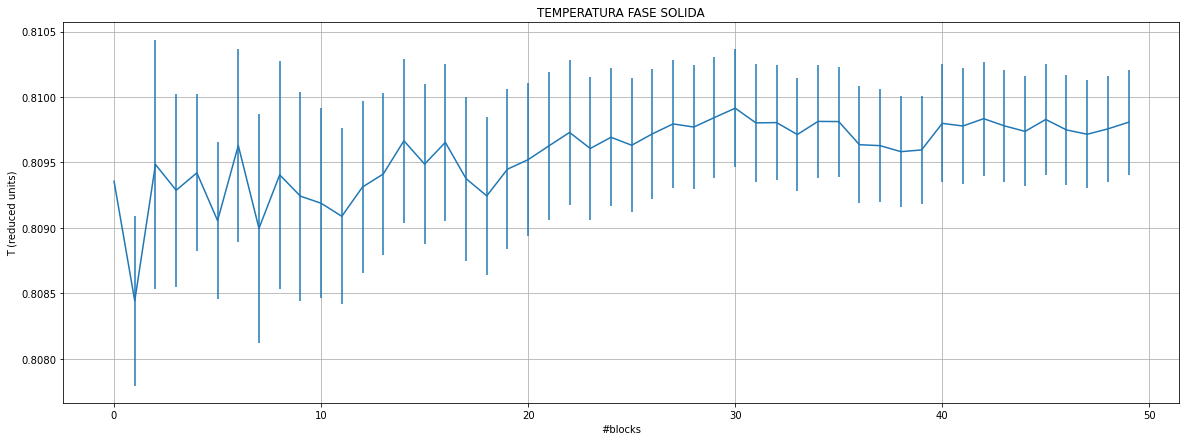

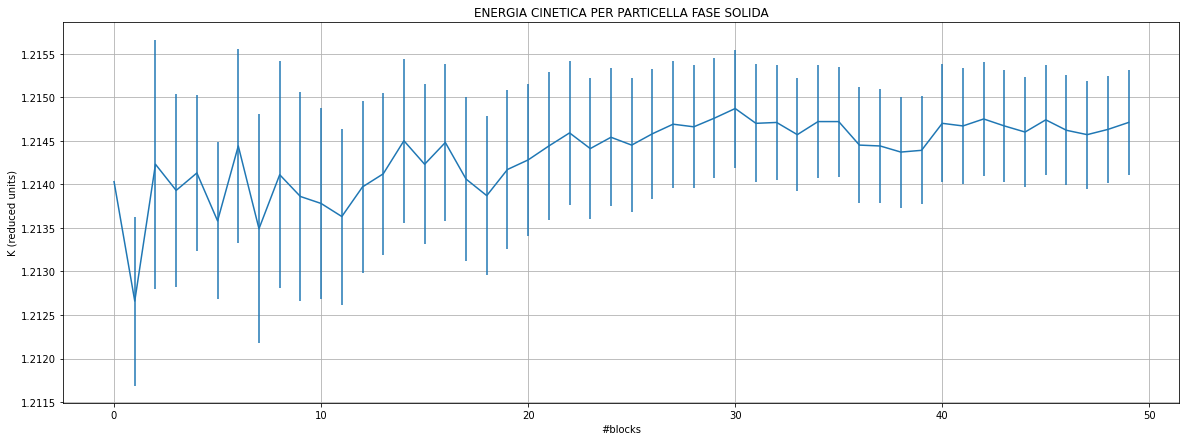

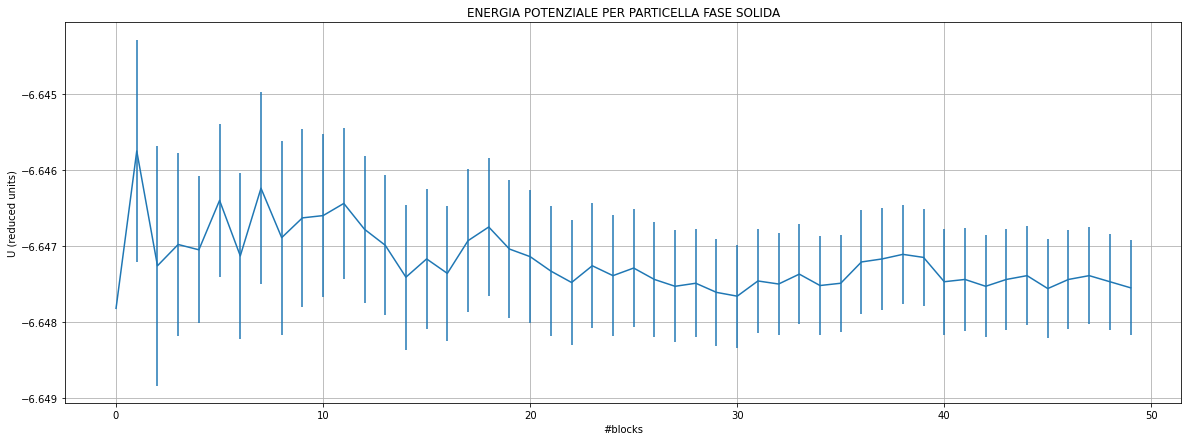

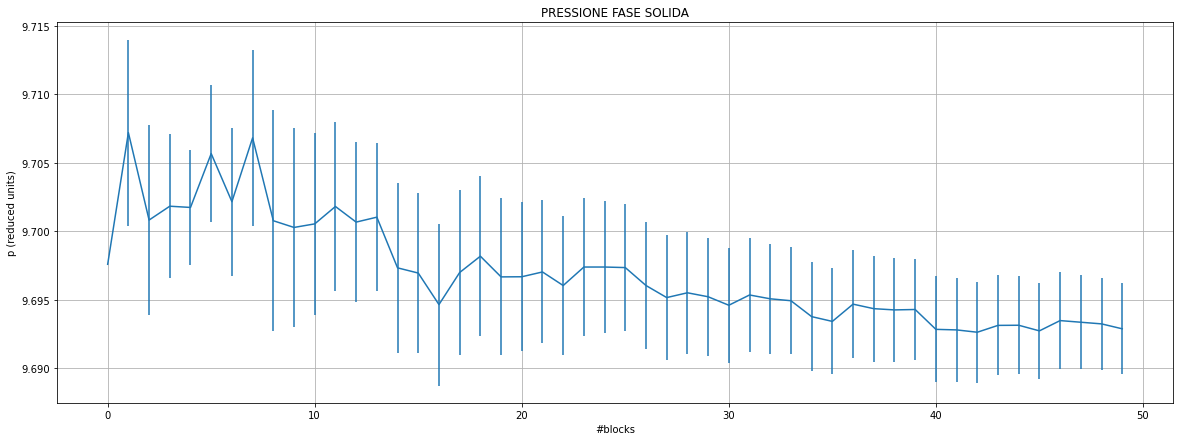

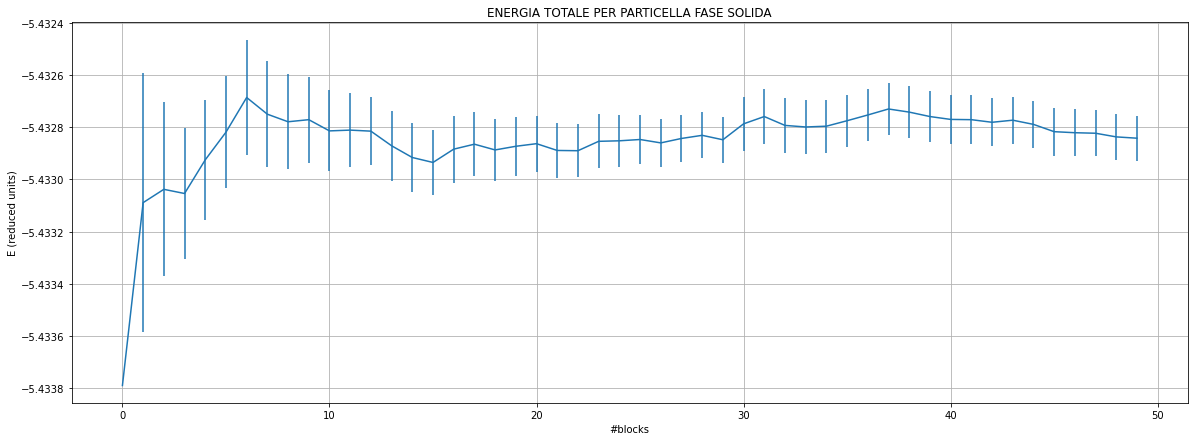

In [12]:
import matplotlib.pyplot as plt
import numpy as np

f, error = np.loadtxt("output_temp_SOL", usecols=(2,3), unpack='true')
x = np.arange(f.size)
plt.figure(figsize=(20,7))
plt.errorbar(x,f,error)
plt.title('TEMPERATURA FASE SOLIDA')
plt.xlabel('#blocks')
plt.ylabel('T (reduced units)')
#plt.plot([0,10000],[1.1,1.1], color="red")
plt.grid(True)
plt.show()


f, error = np.loadtxt("output_ekin_SOL", usecols=(2,3), unpack='true')
x = np.arange(f.size)
plt.figure(figsize=(20,7))
plt.errorbar(x,f,error)
plt.title('ENERGIA CINETICA PER PARTICELLA FASE SOLIDA')
plt.xlabel('#blocks')
plt.ylabel('K (reduced units)')
#plt.plot([0,10000],[1.1,1.1], color="red")
plt.grid(True)
plt.show()

f, error = np.loadtxt("output_epot_SOL", usecols=(2,3), unpack='true')
x = np.arange(f.size)
plt.figure(figsize=(20,7))
plt.errorbar(x,f,error)
plt.title('ENERGIA POTENZIALE PER PARTICELLA FASE SOLIDA')
plt.xlabel('#blocks')
plt.ylabel('U (reduced units)')
#plt.plot([0,10000],[1.1,1.1], color="red")
plt.grid(True)
plt.show()

f, error = np.loadtxt("output_pres_SOL", usecols=(2,3), unpack='true')
x = np.arange(f.size)
plt.figure(figsize=(20,7))
plt.errorbar(x,f,error)
plt.title('PRESSIONE FASE SOLIDA')
plt.xlabel('#blocks')
plt.ylabel('p (reduced units)')
#plt.plot([0,10000],[1.1,1.1], color="red")
plt.grid(True)
plt.show()

f, error = np.loadtxt("output_etot_SOL", usecols=(2,3), unpack='true')
x = np.arange(f.size)
plt.figure(figsize=(20,7))
plt.errorbar(x,f,error)
plt.title('ENERGIA TOTALE PER PARTICELLA FASE SOLIDA')
plt.xlabel('#blocks')
plt.ylabel('E (reduced units)')
#plt.plot([0,10000],[1.1,1.1], color="red")
plt.grid(True)
plt.show()

#### FASE LIQUIDA

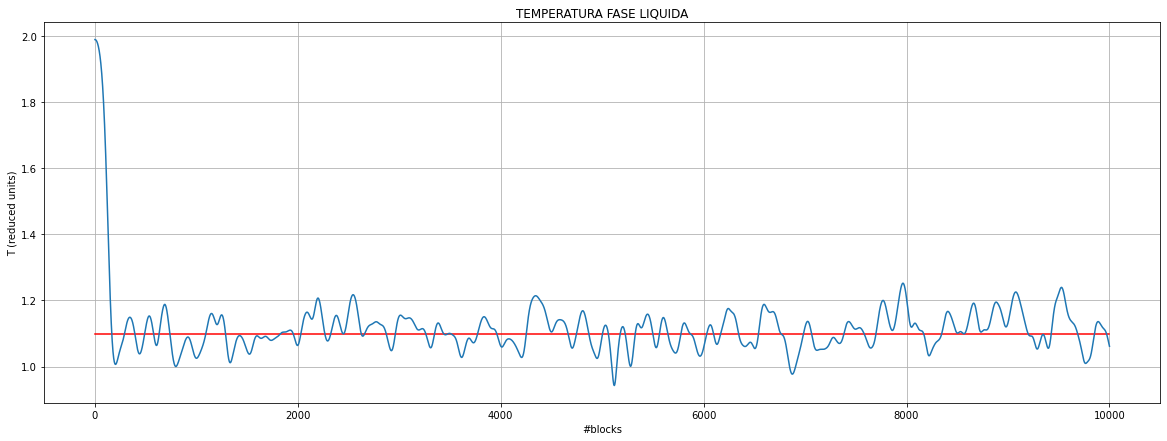

In [4]:
import matplotlib.pyplot as plt
import numpy as np

f = np.loadtxt("output_temp_liq1", usecols=(1), unpack='true')
x = np.arange(f.size)
plt.figure(figsize=(20,7))
plt.errorbar(x,f)
plt.title('TEMPERATURA FASE LIQUIDA')
plt.xlabel('#blocks')
plt.ylabel('T (reduced units)')
plt.plot([0,10000],[1.1,1.1], color="red")
plt.grid(True)
plt.show()

In questo caso si può vedere che dopo pochi step i valori sono prossimi a quello atteso ma sono presenti oscillazioni periodiche. Dopo 3000 step la simulazione si stabilizza e l'andamento delle oscillazioni rimane pressoché costante. Come tempo di equilibrazione è stato scelto 3000 passi. 

E' quindi stato implementato un ciclo for dove si fa fare 3000 step prima di far partire la simulazione vera e propria

Per poter avere una simulazione più accurata visto l'andamento dei valori e visto che questo andamento si ripete tendenzialmente ogni 2000 step i blocchi sono lunghi 2000 step.

Sono riportati sotto i grafici delle medie e incertezze progressive delle grandezze considerate:

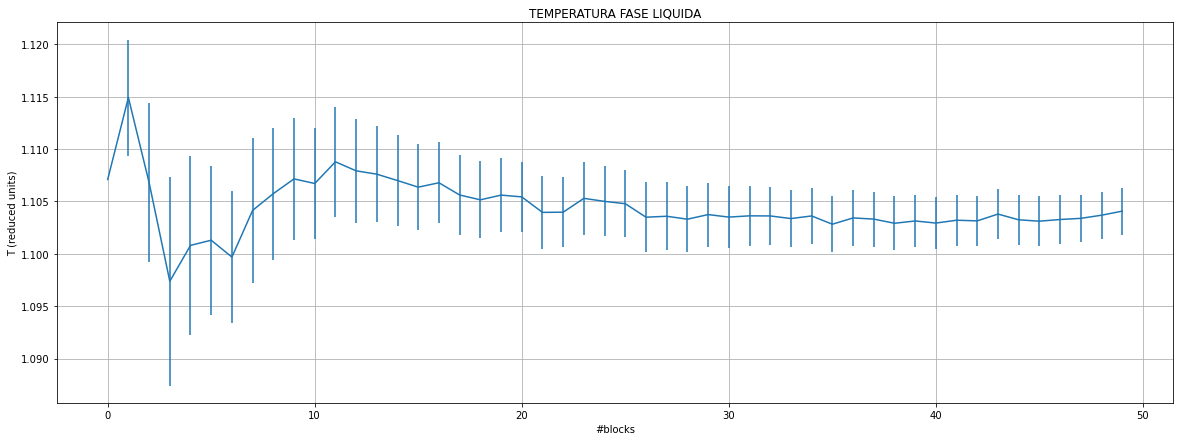

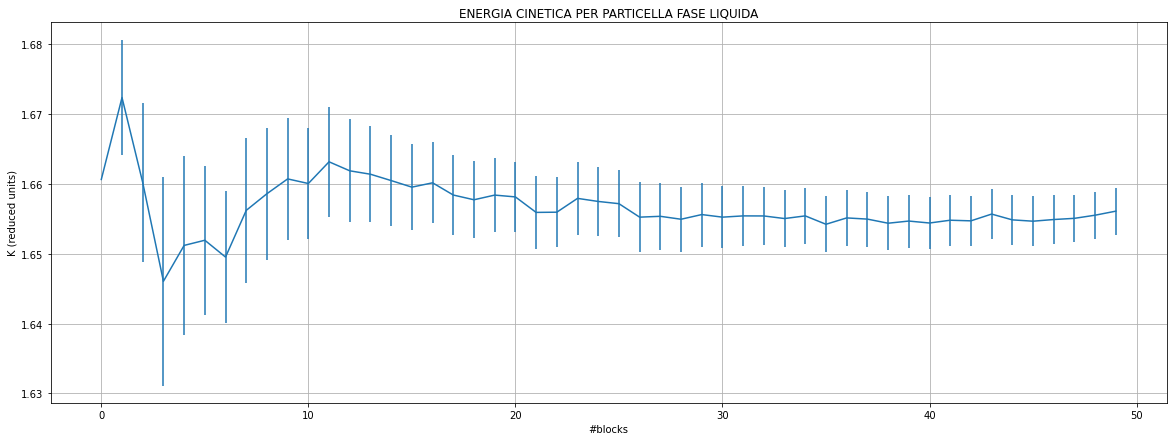

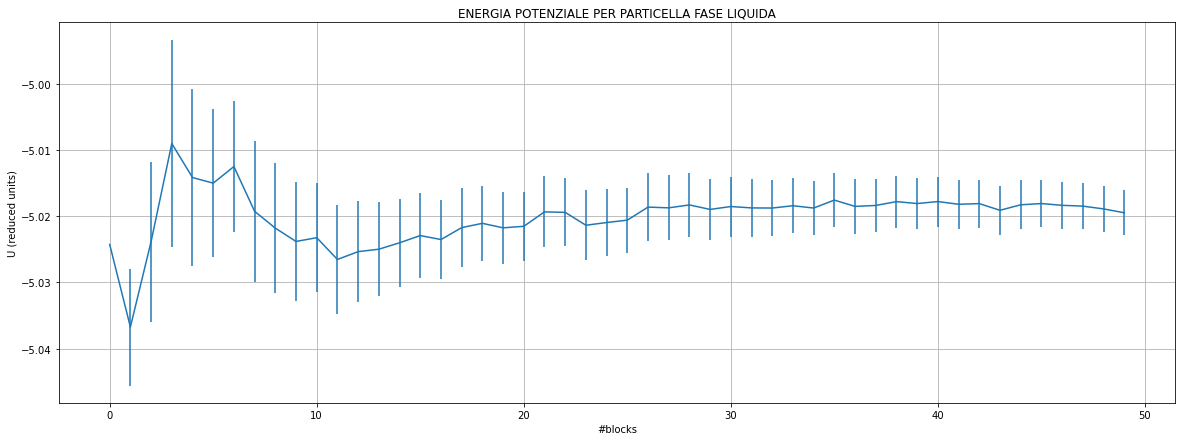

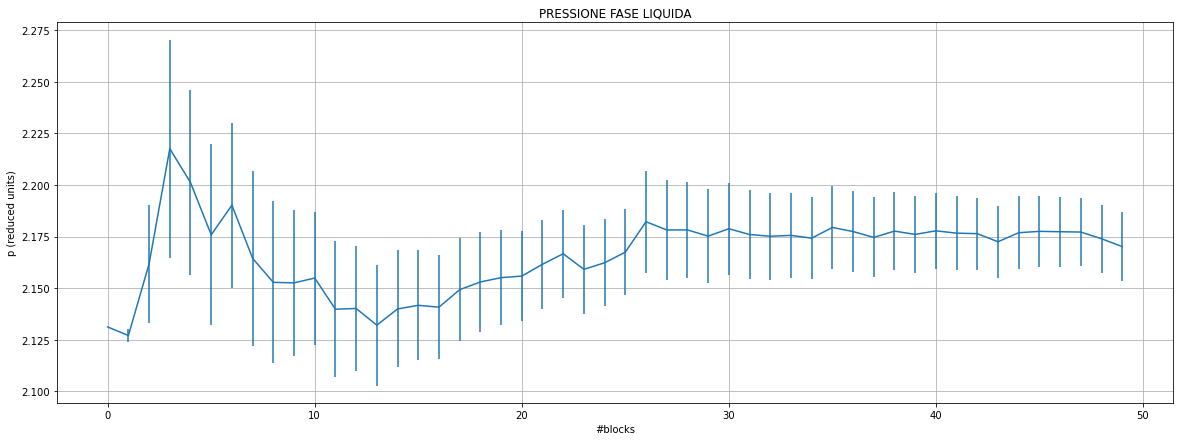

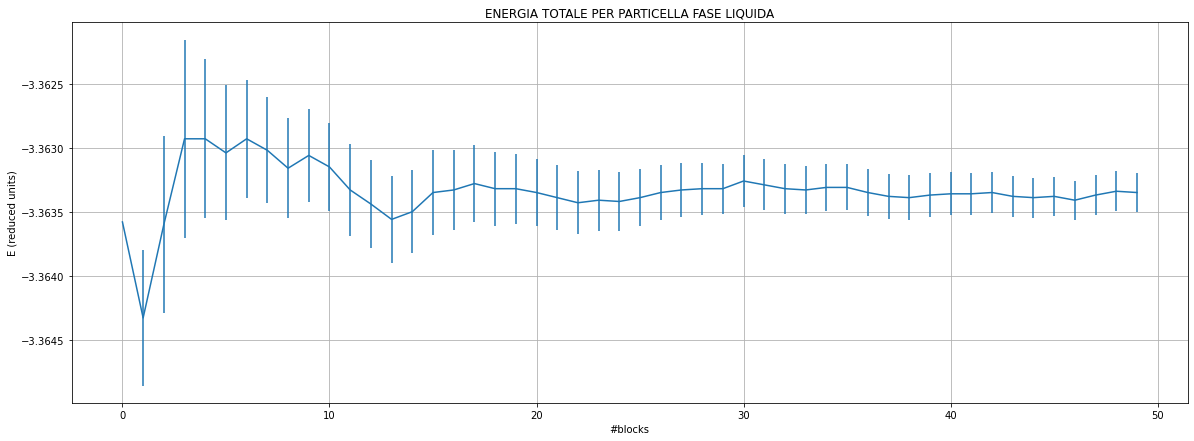

In [14]:
import matplotlib.pyplot as plt
import numpy as np

f, error = np.loadtxt("output_temp_LIQ", usecols=(2,3), unpack='true')
x = np.arange(f.size)
plt.figure(figsize=(20,7))
plt.errorbar(x,f,error)
plt.title('TEMPERATURA FASE LIQUIDA')
plt.xlabel('#blocks')
plt.ylabel('T (reduced units)')
#plt.plot([0,10000],[1.1,1.1], color="red")
plt.grid(True)
plt.show()

f, error = np.loadtxt("output_ekin_LIQ", usecols=(2,3), unpack='true')
x = np.arange(f.size)
plt.figure(figsize=(20,7))
plt.errorbar(x,f,error)
plt.title('ENERGIA CINETICA PER PARTICELLA FASE LIQUIDA')
plt.xlabel('#blocks')
plt.ylabel('K (reduced units)')
#plt.plot([0,10000],[1.1,1.1], color="red")
plt.grid(True)
plt.show()

f, error = np.loadtxt("output_epot_LIQ", usecols=(2,3), unpack='true')
x = np.arange(f.size)
plt.figure(figsize=(20,7))
plt.errorbar(x,f,error)
plt.title('ENERGIA POTENZIALE PER PARTICELLA FASE LIQUIDA')
plt.xlabel('#blocks')
plt.ylabel('U (reduced units)')
#plt.plot([0,10000],[1.1,1.1], color="red")
plt.grid(True)
plt.show()

f, error = np.loadtxt("output_pres_LIQ", usecols=(2,3), unpack='true')
x = np.arange(f.size)
plt.figure(figsize=(20,7))
plt.errorbar(x,f,error)
plt.title('PRESSIONE FASE LIQUIDA')
plt.xlabel('#blocks')
plt.ylabel('p (reduced units)')
#plt.plot([0,10000],[1.1,1.1], color="red")
plt.grid(True)
plt.show()

f, error = np.loadtxt("output_etot_LIQ", usecols=(2,3), unpack='true')
x = np.arange(f.size)
plt.figure(figsize=(20,7))
plt.errorbar(x,f,error)
plt.title('ENERGIA TOTALE PER PARTICELLA FASE LIQUIDA')
plt.xlabel('#blocks')
plt.ylabel('E (reduced units)')
#plt.plot([0,10000],[1.1,1.1], color="red")
plt.grid(True)
plt.show()



#### FASE GASSOSA

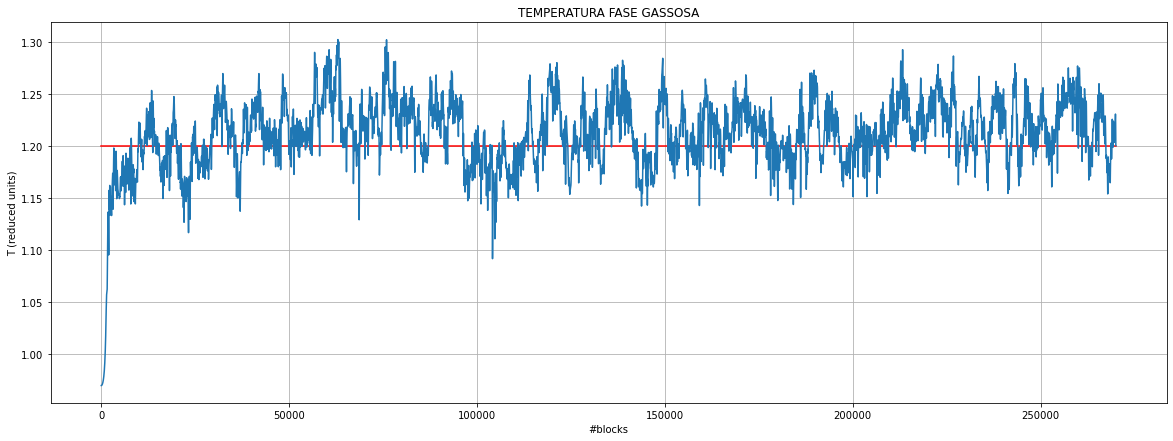

In [3]:
import matplotlib.pyplot as plt
import numpy as np

f = np.loadtxt("output_temp_gas1", usecols=(1), unpack='true')
x = np.arange(f.size)
plt.figure(figsize=(20,7))
plt.errorbar(x,f)
plt.title('TEMPERATURA FASE GASSOSA')
plt.xlabel('#blocks')
plt.ylabel('T (reduced units)')
plt.plot([0,270000],[1.2,1.2], color="red")
plt.grid(True)
plt.show()

Nel caso della fase gassosa si può notare come le oscillazioni siano molto più ampie e sopratutto lente. Nel primo caso questo è dovuto anche al fatto che stiamo considerando una fase gassosa che però iniza a manifestare comportamenti caratteristici della fase liquida, quindi piccole aggregazioni di particelle che impiegano diverso tempo per disgregarsi, vicino a quelle del punto critico. In secondo luogo la temperatura $T^\star$ è vicino alla tempertatura critica e questo porta a delle variazioni su scala sempre maggiore.

Dopo 120000 step la simulazione si stabilizza e l'andamento delle oscillazioni rimane pressoché costante. Come tempo di equilibrazione è stato scelto 120000 passi. 

E' quindi stato implementato un ciclo for dove si fa fare 120000 step prima di far partire la simulazione vera e propria.

Per poter avere una simulazione più accurata visto l'andamento dei valori e visto che questo andamento si ripete tendenzialmente ogni 50000 step i blocchi sono lunghi 50000 step.

Sono riportati sotto i grafici delle medie e incertezze progressive delle grandezze considerate:

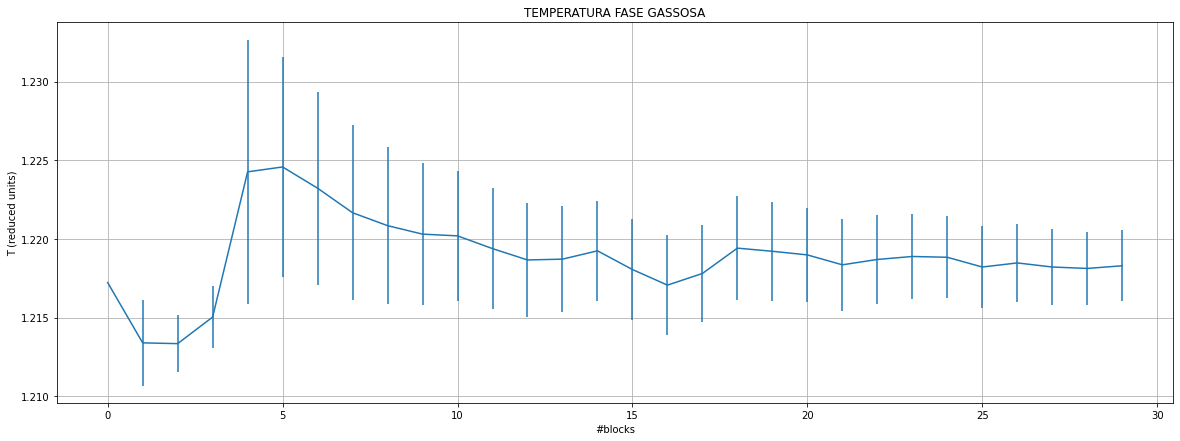

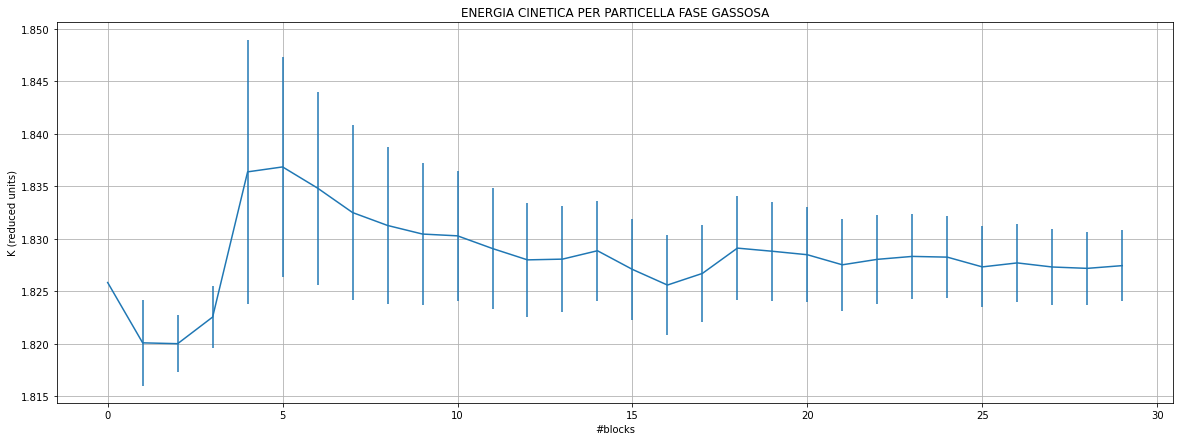

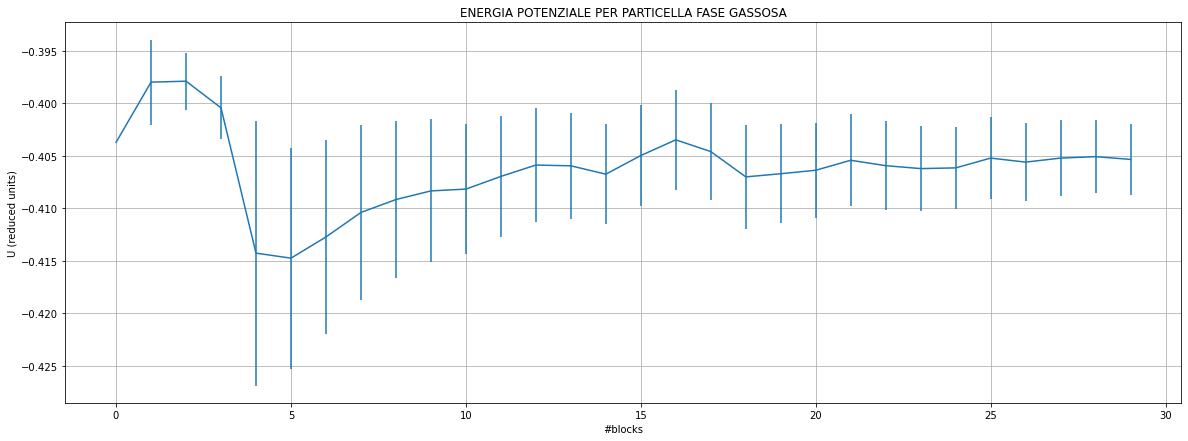

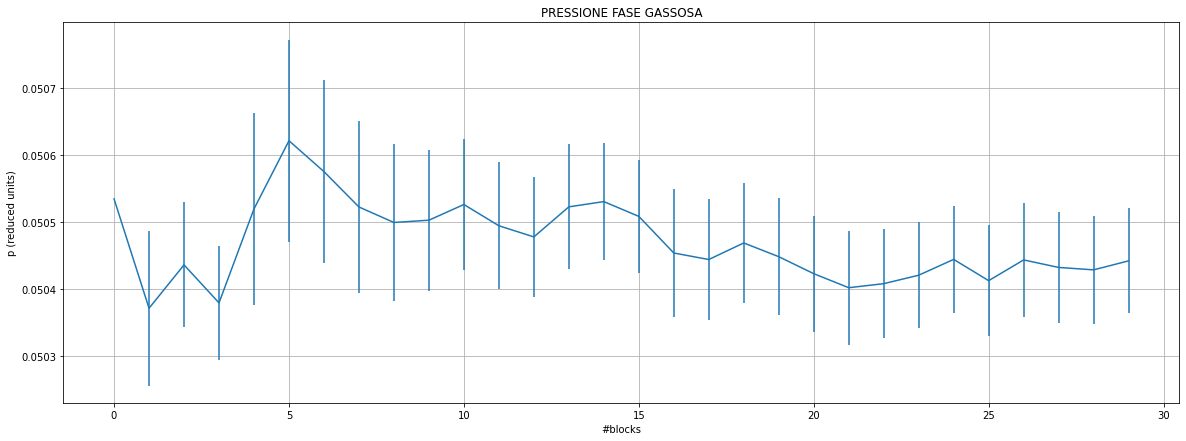

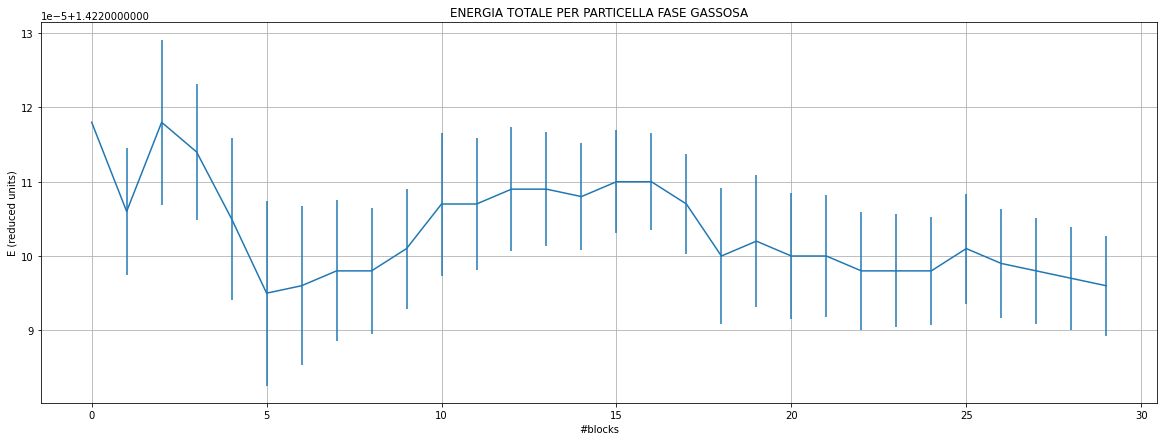

In [8]:
import matplotlib.pyplot as plt
import numpy as np

f, error = np.loadtxt("output_temp_GAS", usecols=(2,3), unpack='true')
x = np.arange(f.size)
plt.figure(figsize=(20,7))
plt.errorbar(x,f,error)
plt.title('TEMPERATURA FASE GASSOSA')
plt.xlabel('#blocks')
plt.ylabel('T (reduced units)')
#plt.plot([0,10000],[1.1,1.1], color="red")
plt.grid(True)
plt.show()

f, error = np.loadtxt("output_ekin_GAS", usecols=(2,3), unpack='true')
x = np.arange(f.size)
plt.figure(figsize=(20,7))
plt.errorbar(x,f,error)
plt.title('ENERGIA CINETICA PER PARTICELLA FASE GASSOSA')
plt.xlabel('#blocks')
plt.ylabel('K (reduced units)')
#plt.plot([0,10000],[1.1,1.1], color="red")
plt.grid(True)
plt.show()

f, error = np.loadtxt("output_epot_GAS", usecols=(2,3), unpack='true')
x = np.arange(f.size)
plt.figure(figsize=(20,7))
plt.errorbar(x,f,error)
plt.title('ENERGIA POTENZIALE PER PARTICELLA FASE GASSOSA')
plt.xlabel('#blocks')
plt.ylabel('U (reduced units)')
#plt.plot([0,10000],[1.1,1.1], color="red")
plt.grid(True)
plt.show()

f, error = np.loadtxt("output_pres_GAS", usecols=(2,3), unpack='true')
x = np.arange(f.size)
plt.figure(figsize=(20,7))
plt.errorbar(x,f,error)
plt.title('PRESSIONE FASE GASSOSA')
plt.xlabel('#blocks')
plt.ylabel('p (reduced units)')
#plt.plot([0,10000],[1.1,1.1], color="red")
plt.grid(True)
plt.show()

f, error = np.loadtxt("output_etot_GAS", usecols=(2,3), unpack='true')
x = np.arange(f.size)
plt.figure(figsize=(20,7))
plt.errorbar(x,f,error)
plt.title('ENERGIA TOTALE PER PARTICELLA FASE GASSOSA')
plt.xlabel('#blocks')
plt.ylabel('E (reduced units)')
#plt.plot([0,10000],[1.1,1.1], color="red")
plt.grid(True)
plt.show()


Si può notare da tutti i grafici precedenti come al crescere dei blocchi ci sia un'effettiva convergenza della media progressiva. In particolare per quanto riguarda la temperatura essa si assesta attorno ad un valore prossimo a quello atteso ma non rientrante nel margine di errore. Questo è dovuto al fatto che la stima della temperatura inizale necessaria per arrivare alla temperatura $T^\star$ non è stata effettuata in modo preciso anche perché nell'argomento le configurazioni sono generate a partire dalle posizioni. Questa, seppur piccola, sovrastima della temperatura di partenza ha fatto sì che avendo una simulazione abbastanza lunga come in questo caso, e sufficientemente equilibrata in precedenza, le oscillazioni siano troppo piccole per comprendere anche il valore atteso.

I risultati ottenuti rimangono comunque consistenti.